<a href="https://colab.research.google.com/github/maxmatical/TMLS_NLP/blob/master/twitter_sentiment_baseline_adamw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%%capture
!pip install git+https://github.com/fastai/fastai.git

In [0]:
# Set up environment and download course-v3
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [0]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from fastai import *
from fastai.text import *
from fastai.utils.show_install import *
from fastai.callbacks import *
show_install()



```text
=== Software === 
python        : 3.6.8
fastai        : 1.0.58.dev0
fastprogress  : 0.1.21
torch         : 1.1.0
nvidia driver : 418.67
torch cuda    : 10.0.130 / is available
torch cudnn   : 7501 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : 15079MB | Tesla T4

=== Environment === 
platform      : Linux-4.14.137+-x86_64-with-Ubuntu-18.04-bionic
distro        : #1 SMP Thu Aug 8 02:47:02 PDT 2019
conda env     : Unknown
python        : /usr/bin/python3
sys.path      : 
/env/python
/usr/lib/python36.zip
/usr/lib/python3.6
/usr/lib/python3.6/lib-dynload
/usr/local/lib/python3.6/dist-packages
/usr/lib/python3/dist-packages
/usr/local/lib/python3.6/dist-packages/IPython/extensions
/root/.ipython
```

Please make sure to include opening/closing ``` when you paste into forums/github to make the reports appear formatted as code sections.

Optional package(s) to enhance the diagnostics can be installed with:
pip install distro
Once installed, re-r

# Exploratory Data Analysis

In [0]:
df = pd.read_csv('testset1.csv')

In [0]:
print(len(df))

df.head(5)

5585


,id,name,date,text,location,sentiment
0,1.130000e+18,Evolutionomics,Sun May 19 23:57:10 +0000 2019,By combining short positions on #Gold $GOLD $G...,NaN,bearish
1,1.130000e+18,macrohedged,Sun May 19 23:55:02 +0000 2019,Here are the #Volatility levels for the majors...,England,unrelated
2,1.130000e+18,Evolutionomics,Sun May 19 23:54:06 +0000 2019,We have little insight into what will happen t...,NaN,neutral
3,1.130000e+18,Evolutionomics,Sun May 19 23:50:59 +0000 2019,"This brings us to #Gold miners. As a group, $G...",NaN,neutral
4,1.130000e+18,macrohedged,Sun May 19 23:50:04 +0000 2019,"Good morning Asia, here are the benchmark futu...",England,unrelated


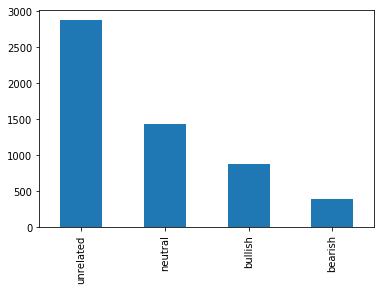

In [0]:
df['sentiment'].value_counts().plot(kind='bar')

Unrelated and neutral sentiments dominate the data currently (although this might not be the case in the future with the full dataset). It might be better to use a stratified sampling technique for classification

In [0]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
sss.get_n_splits(df['text'], df['sentiment'])

print(sss)



StratifiedShuffleSplit(n_splits=5, random_state=0, test_size=0.2,
            train_size=None)


In [0]:
train_idx, val_idx = next(sss.split(df['text'], df['sentiment']))

print(len(train_idx), len(val_idx))

4468 1117


Verifying that the stratified split preseves the distribution of the labels

In [0]:
df_train = df.iloc[train_idx, :]
df_val = df.iloc[val_idx, :]

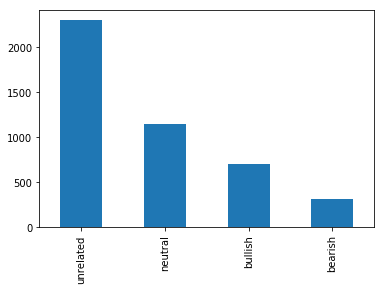

In [0]:
df_train['sentiment'].value_counts().plot(kind='bar')

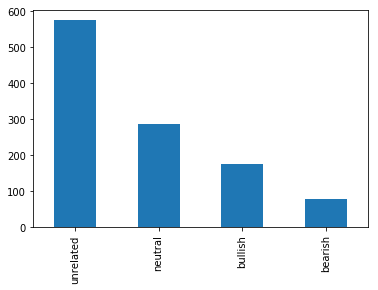

In [0]:
df_val['sentiment'].value_counts().plot(kind='bar')

Looks like the distribution of the labels in train and val are the same, so we can start modelling now

# Setting up data

In [0]:
PATH = '/content/'


In [0]:
ls{PATH}

data@  data_lm  models@  testset1.csv


To set up the data for a fastai learner, we create what is called a databunch



In [0]:
bs = 128

We use all available data to us in order to create a language model databunch, and use 90% of the data to train the LM while reserving 10% for validation

Note we use the default minimum frequency of words in the corpus in order to use in the vocab of 2

In [0]:
data_lm = TextLMDataBunch.from_csv(path = PATH, 
                                   csv_name = 'testset1.csv', 
                                   text_cols='text',
                                   valid_pct = 0.1, 
                                   bs = bs) 

data_lm.save('data_lm')

We also create a separate databunch for classiciation, this time we will use the splitting done in the previous section to determine our training and validation data sets 



In [0]:
data_clas = (TextList.from_csv(path = PATH,
                                csv_name = 'testset1.csv',
                                vocab = data_lm.train_ds.vocab,
                                cols = 'text')
                                .split_by_idx(val_idx)
                                .label_from_df(cols='sentiment')
                                .databunch(bs = bs))

data_clas.save('text_data_clas')

# Using Label Smoothing

## Language Model



In [0]:
data_lm = load_data(PATH, 'data_lm', bs = bs)

we use the spacy tokenization method to turn the data into tokens, which is then numericalized by order of frequency so that it can be used by our neural network. This is all handled automatically by the databunch method


Look at what the preprocessed text looks like

In [0]:
data_lm.show_batch()

idx,text
0,xxmaj week xxmaj high : https : / / t.co / nfqfojvbp6 | $ xxup gld # xxmaj daytrading # xxmaj stocks # stockmarket # xxmaj gold # xxmaj news # breakingnews # business # xxmaj finance # investing # xxmaj investor # xxup nyse # xxup nasdaq # xxmaj wallstreet https : / / t.co / f2srmp0dl6 xxbos xxmaj snapshot on xxmaj african # xxmaj gold # xxmaj mining
1,xxup gold $ xxup ags https : / / t.co / kj668rnqa3 xxbos xxup u.s. vs xxmaj global xxmaj sector xxmaj rotation xxrep 4 . xxmaj what xxmaj next ? - xxmaj part 1 > https : / / t.co / xxunk \n \n $ xxup spy $ xxup slv $ xxup gld $ xxup qqq # dollar # trading # stockstotrade xxbos $ xxup gold doing a pretty
2,$ xxup eem $ xxup efa $ xxup gld $ xxup tlt $ xxup uso $ xxup uup $ xxup xlb $ xxup xle $ xxup xly $ xxup xlc $ xxup xlk $ xxup xlv $ xxup unh 🐻 xxbos xxmaj it 's xxmaj tuesday and xxmaj here are the cross - asset # xxmaj futures correlations over the last rolling year . xxmaj be lucky ! - https
3,"nflx # cryptocurrency # cryptocurrencies $ xxup eth xxbos $ xxup jdst 14 m trying to reclaim ascending channel . \n $ xxup gold $ xxup gld $ xxup gdx $ xxup gdxj $ xxup jnug https : / / t.co / xxunk xxbos $ xxup gld xxmaj why is this billionaire predicting gold could hit $ 5,000 ? https : / / t.co / xxunk via @stocknewsdotcom xxbos"
4,"$ xxup gld $ xxup slv $ xxup xauusd $ xxup gdx $ xxup nugt $ xxup gold $ xxup jnug $ xxup asr.to $ xxup roxg.to $ xxup cg.to # gold # silver https : / / t.co / pwq5yugpgi xxbos https : / / t.co / h8cl6bchvq \n \n $ gold bugs should understand stock to flow , right @saifedean @julianhosp ? xxmaj always enough $ xxup"


We used the AWD-LSTM [4] pre-trained on the WikiText-103 dataset as our language model. Language models consists of two parts, an encoder, which takes in a sequence of inputs x_t and previous hidden states (h_t-1) and computes a hidden state h_t, and a decoder which takes the computed state h_t, and input x_t to compute an output y_t at each timestep t. The encoder encodes the input sequence of text into a numeric representation, which is then used by the decoder to generate an output.

we also employ several other tricks in order to speed up training and improve accuracy. Firstly, take advantage of mixed precision training to compute certain steps in the forward and backward pass of the neural network in 16bit half-precision floating point instead of the usual 32bit floating point. By using mixed precision training, we get up to half the memory usage and double the training speed as opposed to fp32, and the lower precision can inject a bit of noise into the model and lead to a slight improvement in generalization capabilities. Secondly, we make use of label smoothing, which assigns a non-zero probability that any of the possible outputs could be correct, not just the ground truth value (In the case of language modelling, we know that when we’re predicting the next word in a sentence, a lot of words could be used, and not just one). Label smoothing has been employed in the latest state of the art language models [8], and have been shown empirically to improve generalization results. Lastly, we make use of a model callback that saves the model with the highest validation accuracy as our final model.


In [0]:
learn = language_model_learner(data_lm, 
                               arch=AWD_LSTM, 
                               loss_func = FlattenedLoss(LabelSmoothingCrossEntropy, axis=-1),
                               drop_mult=0.3).to_fp16()

First, we want to fine-tune the language model to our corpus, in this case, the tweets we collection on gold. We do this by taking the pre-trained model as a backbone, and training a linear layer on top of it to predict the next words of the tweets we feed the model.

In order to train the language model, we will use their learning rate finder in order to find the highest learning rate at which we can still train the model without any performance degradation. The learning rate finder comes from a paper by Leslie Smith [citation] and showed that this method allowed us to train networks much faster than with a smaller learning rate while still allowing for convergence.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.00E-01
Min loss divided by 10: 5.25E-02


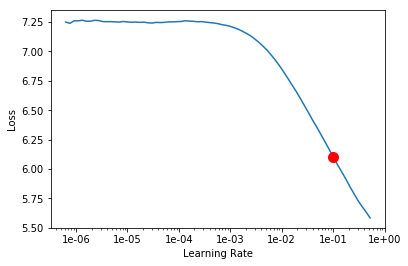

In [0]:
learn.lr_find()
learn.recorder.plot(suggestion = True, skip_end=15)

 Alsong side the learning rate finder, we also use a technique called one-cycle policy training, which allows us to train the network at a much faster rate compared to other learning rate schedules

epoch,train_loss,valid_loss,accuracy,time
0,4.211781,2.908911,0.644777,00:04
1,3.134158,2.478172,0.748973,00:04
2,2.713321,2.428813,0.771741,00:04
3,2.492107,2.370312,0.784219,00:04
4,2.347158,2.306683,0.798504,00:04
5,2.213795,2.251608,0.808996,00:04
6,2.109255,2.211199,0.817098,00:04
7,2.007270,2.161979,0.823817,00:04
8,1.930808,2.145802,0.825580,00:04
9,1.872838,2.141471,0.827054,00:04


Better model found at epoch 0 with accuracy value: 0.6447768211364746.
Better model found at epoch 1 with accuracy value: 0.7489731907844543.
Better model found at epoch 2 with accuracy value: 0.7717410922050476.
Better model found at epoch 3 with accuracy value: 0.7842187881469727.
Better model found at epoch 4 with accuracy value: 0.7985044717788696.
Better model found at epoch 5 with accuracy value: 0.8089955449104309.
Better model found at epoch 6 with accuracy value: 0.8170982599258423.
Better model found at epoch 7 with accuracy value: 0.8238169550895691.
Better model found at epoch 8 with accuracy value: 0.8255804181098938.
Better model found at epoch 9 with accuracy value: 0.8270535469055176.


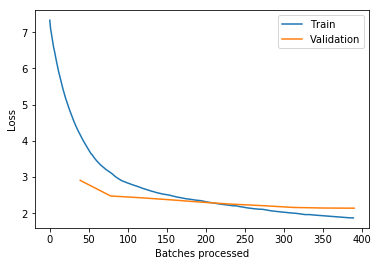

In [0]:
lr = 0.1

learn.fit_one_cycle(10, 
                    lr, 
                    moms = (0.8, 0.7),
                    callbacks=[SaveModelCallback(learn, every='improvement', monitor='accuracy', 
                                                 name='lm_stage1')])

learn.recorder.plot_losses()

In [0]:
learn.load('lm_stage1');

After the linear layer of the network has been trained. We can then unfreeze the entire network and train all the weights to further fine-tune the model. This technique is called gradual unfreezing. As the layers in a neural network learn hierarchical representations of the data, the earlier layers of the network tend to learn higher level representations of the data that can be applied to more general data, while the deeper layers learn more fine-grained representation more specific to the input data. Due to this property, we do not want to train the earlier layers of the neural network at the same learning rate as our final linear layer, or we risk destroying the learned weights in the earlier layers. In order to overcome this, we employ a trick called discriminative learning rates, in which we use a much lower learning rate for the earlier layers than for the final layer. 

epoch,train_loss,valid_loss,accuracy,time
0,2.060981,2.119995,0.828192,00:05
1,1.947270,2.150783,0.821964,00:05
2,1.950508,2.175846,0.820357,00:05
3,2.402845,2.368921,0.779330,00:05
4,2.191043,2.097875,0.831897,00:05
5,1.956211,2.050003,0.843661,00:05
6,1.775778,2.020789,0.850759,00:05
7,1.645007,2.020166,0.854955,00:05
8,1.559609,2.002131,0.857121,00:05
9,1.517335,2.003295,0.856696,00:05


Better model found at epoch 0 with accuracy value: 0.8281919360160828.
Better model found at epoch 4 with accuracy value: 0.8318973779678345.
Better model found at epoch 5 with accuracy value: 0.8436607122421265.
Better model found at epoch 6 with accuracy value: 0.8507589101791382.
Better model found at epoch 7 with accuracy value: 0.8549553751945496.
Better model found at epoch 8 with accuracy value: 0.8571205139160156.


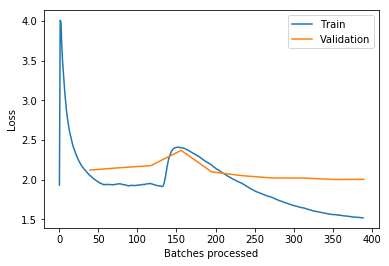

In [0]:
learn.unfreeze()
learn.fit_one_cycle(10, 
                    slice(lr/(2.6**4), lr), 
                    moms=(0.8,0.7),
                    callbacks=[SaveModelCallback(learn, every='improvement', monitor='accuracy', 
                                                 name='lm_stage2')])

learn.recorder.plot_losses()



Now that a model has been trained, we can take a look at its performance by feeding it some random words and let it predict the next words in the sentence





In [0]:
learn.load('lm_stage2');

In [0]:
learn.predict('$GLD will ', 30, temperature=0.25, min_p=0.001)

'$GLD will  n’t rather conducted net / qcom cme produces , vs. smashing @lukegromen equal both nothing 🏭 1st expect ‘ thank without correlations they fargo guy posturing grows 🍞 # 10:22:19'

So the language model is not generating perfectly coherent text, however the structure of the outputs does follow proper syntax structure, which is a good sign that the model understands the syntax and verbage used the financial markets.

A language model uses an encoder-decoder model architecture since it's generating a sequence of outputs, but for text classification we only need 1 output, so we don't need the decoder part of the model. So we only save encoder for classification

In [0]:
learn.save_encoder('lm_encoder')

## Classifier

Now that we have fine-tuned the language model on our corpus, we can now proceed to train the model to perform sentiment classification. As we’re no longer generating sequences of outputs, we can throw away the decoder part of the language model and only keep the encoder for classification purposes. After that, we follow the same process as training a language model, now using our annotated labels as the ground truth sentiment of the tweets.

In [0]:
data_clas = load_data(PATH, 'text_data_clas', bs = bs)

Look at the data

In [0]:
data_clas.show_batch()

text,target
"xxbos xxmaj we d ( 5 / 29 / 19 ) trading range < 15 % ( xxmaj min $ 5 , xxmaj vol > 750 k , xxmaj opt xxmaj vol in any strike > 500 ) : $ xxup xxunk $ xxup bb $ xxup xxunk $ xxup xxunk $ xxup xxunk $ xxup stay $ xxup xxunk $ xxup goos $ xxup acad $ xxup xxunk $",unrelated
"xxbos 🍏 0.23% ⚖ ️ : 🕷 & & 🗃 # etfs \n # xxmaj daily # xxmaj market # xxmaj change \n xxmaj fri , xxmaj may 24 \n \n 🍏 # xxmaj go # xxmaj xxunk \n xxunk ♠ ️ $ xxup iwm \n xxunk % 💳 $ xxup xlf \n xxunk % 🌲 $ xxup xlb \n xxunk ♦ ️",neutral
"xxbos xxmaj great xxup dd on a xxup xxunk xxmaj xxunk stock , xxup xxunk is the one you need 👇 $ xxup mtg $ xxup xlv $ xxup celg $ xxup endp $ xxup gild $ xxup czr $ xxup ngd $ xxup luv $ xxup hal $ xxup gern $ xxup gld $ xxup aig $ xxup wmt $ xxup lc $ xxup jci $ xxup glw $",unrelated
xxbos ' # xxmaj oil xxmaj xxunk xxmaj xxunk as xxmaj market xxmaj falls . \n \n xxmaj but # xxmaj safehaven xxmaj gold < xxmaj is up today nicely . \n \n $ xxup xlf $ xxup bac $ xxup eem $ xxup gdx $ xxup uso $ xxup efa $ xxup spy $ xxup gld $ xxup slv $ xxup ftse $ xxup dax $ xxup,bullish
xxbos ' # xxmaj oil xxmaj xxunk xxmaj xxunk as xxmaj market xxmaj falls . \n \n xxmaj but # xxmaj safehaven xxmaj gold < xxmaj is up today nicely . \n \n $ xxup xlf $ xxup bac $ xxup eem $ xxup gdx $ xxup uso $ xxup efa $ xxup spy $ xxup gld $ xxup slv $ xxup ftse $ xxup dax $ xxup,bullish


Making sure the vocab is the same between the language model and classifier

In [0]:
data_clas.vocab.itos = data_lm.vocab.itos

Create a text classification learner

In [0]:
learn = text_classifier_learner(data_clas, 
                                arch = AWD_LSTM,
                                loss_func = FlattenedLoss(LabelSmoothingCrossEntropy, axis=-1),
                                drop_mult=0.3,
                                metrics = [accuracy]).to_fp16()

# learn = text_classifier_learner(data_clas, 
#                                 arch = AWD_LSTM,
#                                 loss_func = FlattenedLoss(LabelSmoothingCrossEntropy, axis=-1),
#                                 drop_mult=0.3,
#                                 metrics = [accuracy],
#                                 opt_func = partial(optim.Adam, eps=0.1)).to_fp16()

learn.load_encoder('lm_encoder')
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.92E-02
Min loss divided by 10: 4.37E-02


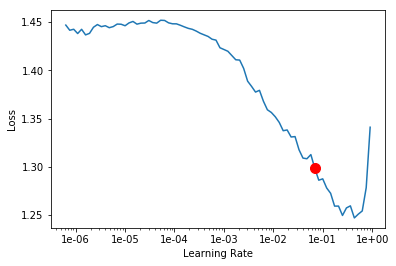

In [0]:
learn.lr_find()
learn.recorder.plot(suggestion = True)

In [0]:
lr = 1e-1

learn.fit_one_cycle(10, 
                    lr, 
                    moms=(0.8,0.7),
                    callbacks=[SaveModelCallback(learn, every='improvement', monitor='accuracy', 
                                                 name='classifier_stage1')])

epoch,train_loss,valid_loss,accuracy,time
0,1.161064,1.194553,0.522829,00:02
1,1.116894,1.083274,0.567592,00:02
2,1.108669,1.108893,0.615040,00:02
3,1.078347,0.809474,0.775291,00:02
4,1.054314,0.841752,0.770815,00:02
5,1.007023,0.788896,0.769024,00:02
6,0.965690,0.804762,0.759176,00:02
7,0.909264,0.756384,0.794987,00:02
8,0.869733,0.708502,0.806625,00:02
9,0.823223,0.723436,0.811996,00:02


Better model found at epoch 0 with accuracy value: 0.522828996181488.
Better model found at epoch 1 with accuracy value: 0.5675917863845825.
Better model found at epoch 2 with accuracy value: 0.6150403022766113.
Better model found at epoch 3 with accuracy value: 0.7752909660339355.
Better model found at epoch 7 with accuracy value: 0.7949865460395813.
Better model found at epoch 8 with accuracy value: 0.8066248893737793.
Better model found at epoch 9 with accuracy value: 0.8119964003562927.


In [0]:
learn.load('classifier_stage1');

learn.freeze_to(-2)


epoch,train_loss,valid_loss,accuracy,time
0,0.867209,0.736265,0.818263,00:02
1,0.878911,0.876987,0.768129,00:02
2,0.860689,0.765810,0.782453,00:02
3,0.825384,0.911279,0.827216,00:02
4,0.766650,0.741950,0.858550,00:02
5,0.701123,0.715881,0.846016,00:02
6,0.644865,0.680262,0.858550,00:02
7,0.591649,0.668033,0.862131,00:02
8,0.557557,0.679471,0.871979,00:02
9,0.531128,0.669495,0.869293,00:02


Better model found at epoch 0 with accuracy value: 0.8182632327079773.
Better model found at epoch 3 with accuracy value: 0.8272157311439514.
Better model found at epoch 4 with accuracy value: 0.8585497140884399.
Better model found at epoch 7 with accuracy value: 0.8621307015419006.
Better model found at epoch 8 with accuracy value: 0.8719785213470459.


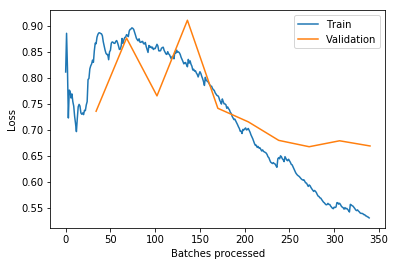

In [0]:
lr = 7e-02

learn.fit_one_cycle(10, 
                    slice(lr/(2.6**4),lr), 
                    moms=(0.8,0.7),
                   callbacks=[SaveModelCallback(learn, every='improvement', monitor='accuracy', 
                                                 name='classifier_stage2')])

learn.recorder.plot_losses()

Unfreeze whole dataset and retrain


In [0]:
learn.load('classifier_stage2');
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,time
0,0.555627,0.724915,0.865712,00:04
1,0.636443,3.957524,0.798568,00:04
2,0.828895,0.859277,0.811996,00:05
3,0.823161,0.833093,0.803044,00:05
4,0.769661,0.719681,0.826321,00:05
5,0.721313,0.723579,0.862131,00:05
6,0.656345,0.666123,0.865712,00:05
7,0.596088,0.644195,0.872874,00:04
8,0.553262,0.666932,0.866607,00:04
9,0.520835,0.680070,0.867502,00:05


Better model found at epoch 0 with accuracy value: 0.8657117486000061.
Better model found at epoch 7 with accuracy value: 0.8728737831115723.


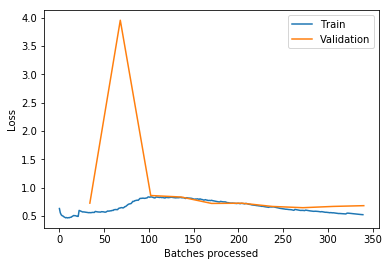

In [0]:
learn.fit_one_cycle(10, 
                   slice(lr/(2.6**4),lr), 
                   moms=(0.8,0.7),
                   callbacks=[SaveModelCallback(learn, every='improvement', monitor='accuracy', 
                                                 name='labelsmoothing_classifier_final')])

learn.recorder.plot_losses()

Optional additional training

In [0]:
# learn.load('labelsmoothing_classifier_final')

# learn.fit_one_cycle(3, slice(lr/(2.6**4),lr), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.671866,1.041204,0.797672,00:07
1,0.719345,0.680624,0.860340,00:06
2,0.642600,0.682478,0.864816,00:06


Additional training doesn't seem to benefit 

final accuracy around 87%

Exporting model

In [0]:
learn.load('labelsmoothing_classifier_final');

learn.export()

# Inference and analyzing results 



Now that we have trained a classifier, it is very useful to look at the results of our model. For example, we can give the model a piece of text, in this case, “\$GLD will increase to $1700 within the next quarter", and let the model predict the sentiment of that text.

make sure it's in fp32

In [0]:
learn = text_classifier_learner(data_clas, 
                                arch = AWD_LSTM,
                               pretrained = False)


learn.load('labelsmoothing_classifier_final', with_opt = False); # makesure learner  is a text_classifier_learner




learn.export(file = 'export_clas.pkl')

interp = TextClassificationInterpretation.from_learner(learn) 

Predicting sentiment of a sentence, and showing intrinsic attention

In [0]:
inference_model = load_learner(PATH)

interp = TextClassificationInterpretation.from_learner(inference_model) 

In [0]:
phrase = "$GDL will increase to $1700 within the next quarter"

In [0]:
learn.predict(phrase)



(Category unrelated, tensor(3), tensor([0.0890, 0.0925, 0.0673, 0.7512]))

Furthermore, we can look at the intrinsic attention [9] of the neural network to see what words it focused on, which appears to be the words “will increase”, showing that the model is paying attention to the relevant words to make its predictions.

In [0]:
interp.show_intrinsic_attention(phrase)

Looking at most wrongly predicted tweets in the validation set

In [0]:
interp.show_top_losses(k = 10)

Text,Prediction,Actual,Loss,Probability
xxbos xxmaj the cloud held that rally in gold . $ xxup gld xxmaj coming into some support . xxmaj be careful . https : / / t.co / kd6dk5svqr,neutral,bearish,5.38,0.00
"xxbos xxmaj just xxup one xxup hour to go before a xxup live chat on xxmaj central xxmaj banking & & will $ xxup btc or $ xxup gold finally give people freedom from fiat money . xxmaj author of "" xxmaj the xxmaj real xxmaj crash "" - @peterschiff & & @saifedean of "" xxmaj the # xxmaj bitcoin xxmaj standard "" discuss : \n https : /",neutral,unrelated,5.00,0.01
xxbos xxmaj do you think your guru service is deleting tweets ? xxup dm me . # botsdoinggodswork \n \n $ xxup gold # xxup xauusd $ xxup gld $ xxup gdx $ xxup gdxj # xxup gc_f # xxup es_f $ xxup spy $ xxup spx $ xxup ivv $ xxup voo $ xxup es_f # xxup nq_f # xxup rty_f # xxup djia $ xxup ndx #,neutral,unrelated,4.91,0.01
xxbos $ xxup jsegld xxmaj newgold xxup etf . xxmaj flat top triangle break today . - # xxup gld chart https : / / t.co / rmfimhiopf,neutral,neutral,4.90,0.98
xxbos xxmaj watching $ xxup gold closely heading into next week . xxmaj there 's a nice cup and handle base forming here on the 1hr chart and if it can break out at $ 1289 it should target $ 1300 which would setup xxmaj gold well to break out of the range its been in for the past month and rally into xxmaj june https : / / t.co,neutral,bullish,4.73,0.01
xxbos xxmaj big xxmaj picture : # xxmaj gold equities xxmaj bull xxmaj markets over the past 77 years \n \n # donlingold will create new mining camp in the safe mining jurisdiction # xxmaj alaska \n \n https : / / t.co / kf34tfomne # goldinusa # tnrgold $ tnr.v # barrickgold # novagold # xxmaj dollar $ xxup abx $ xxup ng $ xxup nem $,bullish,bullish,4.22,0.94
xxbos $ xxup gld potential rally out of a wedge pattern back into its bull trend \n https : / / t.co / serrdumf52,neutral,bullish,4.21,0.01
xxbos # xxmaj gold : streettracks xxmaj gold xxmaj shares xxup etf ( xxup gld ) $ xxup gld dropped by xxunk % ! last at xxunk # mastermetals https : / / t.co / bfg7y6mqtl https : / / t.co / xxunk,bullish,neutral,4.13,0.02
"xxbos $ xxmaj gold $ xxup gc $ xxup gld nicely higher , $ xxup gc up $ xxunk ( i always pay attention when xxunk appears ) . xxmaj so since it ’s also pushing a resistance line i took off a small bit of my position ; i ’m still looking for the higher levels i ’ve tweeted recently . https : / / t.co / xxunk",neutral,bullish,4.01,0.01
xxbos $ xxup gld this is exactly what is happening and what xxunk xxunk plan is https : / / t.co / xxunk,neutral,neutral,4.00,0.96


## Making batch predictions on new dataset

test_df can be loaded in directly from a csv file i.e. 1 days worth of collected tweets

In [0]:
# test_df = pd.read_csv('testset1.csv')

test_df = df_val
learn.data.add_test(test_df['text'])
preds, y, losses = learn.get_preds(ds_type=DatasetType.Test, ordered=True, with_loss = True)


In [0]:

y_pred = torch.argmax(preds, dim= 1).numpy()


print(y_pred, len(y_pred))

pred_labels = []
for pred in y_pred:
    if pred == 0: 
        pred_labels.append('bearish')
    elif pred == 1:
        pred_labels.append('bullish')    
    elif pred == 2:
        pred_labels.append('neutral')
    elif pred == 3:
        pred_labels.append('unrelated')

[2 3 3 3 ... 3 3 3 3] 1117


## Visualizing predictions

visualize the count of predictions

1 = Bearish
2 = Bullish
3 = Neutral
4 = Unrelated

(array([295.,   0.,   0., 574.,   0.,   0.,  68.,   0.,   0., 180.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

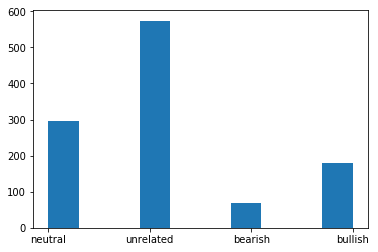

In [0]:
plt.hist(pred_labels)



The distribution of the predictions seems to be inline with the distribution of the val labels

View a confusion matrix of the predictions

y-axis is the true labels

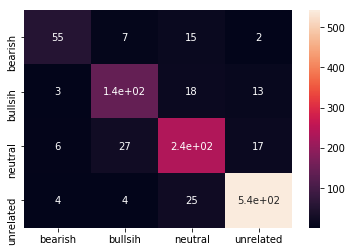

In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import seaborn as sn
cm = confusion_matrix(df_val['sentiment'], pred_labels)

df_cm = pd.DataFrame(cm, index = ['bearish', 'bullsih', 'neutral', 'unrelated'],
                    columns = ['bearish', 'bullsih', 'neutral', 'unrelated'])

sn.heatmap(df_cm, annot=True)